## Capstone Project: Airbnb price recommender web application
------------------------------------------------------------------------------------------------------------------------
### Part 5. Modelling, Evaluation and Model interpretability (Production dataset)

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle
from math import sqrt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

pd.pandas.set_option('display.max_columns', None)

c:\Users\edmun\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\edmun\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\edmun\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Production Model

As it will be difficult for the App user to enter the values for all the features in the model with full features. \
We will create a simpler production model which only requires user input data to generate a price recommendation for new Airbnb listings.

The features required for the production model are:

- Latitude
- Longitude
- Property Type
- Room type
- Number of bedrooms
- Number of bathrooms
- Number of beds
- Bathroom types

In [2]:
listings = pd.read_csv('./data/listings_user_final.csv')

In [3]:
listings.head()

,price,latitude,longitude,property_type,room_type,bedrooms,beds,bathroom_qty,bathroom_type,mrtDisp,nearestMRT,cityDisp
0,80.0,1.33432,103.78521,Apartment,Private room,1.0,1.0,1.0,baths,0.272114,King Albert Park,9.168433
1,145.0,1.34537,103.95887,House,Private room,2.0,3.0,1.0,private,0.456774,Upper Changi,13.932315
2,184.0,1.34490,103.95979,Apartment,Private room,3.0,5.0,3.0,baths,0.353956,Upper Changi,13.995598
3,79.0,1.31142,103.83924,Apartment,Private room,1.0,1.0,1.0,shared,0.300294,Newton,3.347789
4,49.0,1.28828,103.81020,Apartment,Private room,1.0,1.0,0.0,baths,0.748483,Redhill,4.458968


### Importing the datasets

In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2901 entries, 0 to 2900
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          2901 non-null   float64
 1   latitude       2901 non-null   float64
 2   longitude      2901 non-null   float64
 3   property_type  2901 non-null   object 
 4   room_type      2901 non-null   object 
 5   bedrooms       2901 non-null   float64
 6   beds           2901 non-null   float64
 7   bathroom_qty   2901 non-null   float64
 8   bathroom_type  2901 non-null   object 
 9   mrtDisp        2901 non-null   float64
 10  nearestMRT     2901 non-null   object 
 11  cityDisp       2901 non-null   float64
dtypes: float64(8), object(4)
memory usage: 272.1+ KB


#### Categorical Features

#### Dummy encoding of categorical features

In [5]:
# The following columns are categorical and we will use create dummies to encode them
categorical_features = ['property_type', 'room_type', 'bathroom_type','nearestMRT']
# One hot encoding
listings = pd.get_dummies(listings, columns=categorical_features)

### Log transformation of Target variable

We will plot the histogram of the listing prices and then we will perform log transformation to the price as we observe a long right tail in the price column.

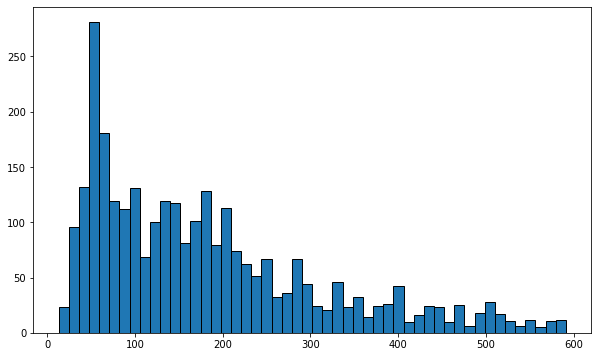

In [6]:
# Plot histogram of target variable
plt.figure(figsize=(10,6))
plt.hist(listings['price'], bins=50, edgecolor='black')
plt.show()

In [7]:
# # Log the price variable
listings['price'] = np.log(listings['price'])

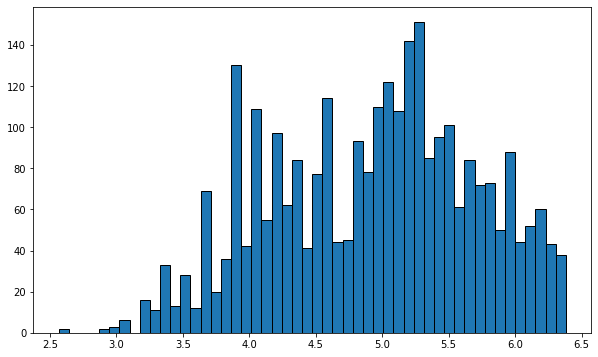

In [9]:
# Plot histogram of target variable
plt.figure(figsize=(10,6))
plt.hist(listings['price'], bins=50, edgecolor='black')
plt.show()

### Split the data into Train and Test sets

In [10]:
# Select the features and target variable
X = listings.drop('price', axis=1)
y = listings['price']

In [11]:
# Perform Train, Test, Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Check the shape of our dataframe
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (2030, 126)
The shape of X_test is (871, 126)
The shape of y_train is (2030,)
The shape of y_test is (871,)


### Min Max Scaling ###

As we are using an XGBoost for the Final production model and since decision tree algorithm do not require feature scaling, we will not perform any feature scaling.

### Modelling

The following supervised machine learning algorithms will be used for the prediction of listing prices of Airbnb in Singapore.
- k-Nearest Neighbours, RandomForest, LightGBM, XGBoost

The regression models will be evaluated with the following metrics
1. R Square
2. Root Mean Square Error

#### Set up Pipelines and Parameters for the different models

#### Pipelines

In [13]:
# k-Nearest Neighbors
pipe_knn = Pipeline([
    ('knn', KNeighborsRegressor())
])


# Random Forest Regressor
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor())
])

# LightGBM Regressor
pipe_lgbm = Pipeline([
    ('lgbm', LGBMRegressor())
])

# XGBoost Regressor
pipe_xgb = Pipeline([
    ('xgb', XGBRegressor())
])

#### Parameters

In [31]:
params_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
}

params_rf = {
    "rf__n_estimators": [100, 150, 200],
    "rf__max_depth": [3, 5, 7, 9],
    'rf__max_features': ['auto'],
    "rf__min_samples_leaf": [2, 3, 4],
    'rf__min_samples_split': [3, 5, 7],
    #'rf__bootstrap': [True, False]
}


params_lgbm = {
    'lgbm__n_estimators': [100, 150, 200],
    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__learning_rate': [0.1,0.2,0.3],
    'lgbm__num_leaves': [5, 10, 20], 
    'lgbm__min_child_samples': [1, 2, 3],
    'lgbm__subsample': [0.3, 0.5, 0.8],
    'lgbm__colsample_bytree': [0.2, 0.5, 0.7],
}

params_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.1,0.2,0.3],
    'xgb__gamma': [4,6,8,10],
    'xgb__min_child_weight': [1,2,3],
    'xgb__subsample': [0.3, 0.5, 0.8],
    'xgb__colsample_bytree': [0.2, 0.5, 0.7],
    'xgb__colsample_bylevel': [0.2, 0.5, 0.7],
    'xgb__alpha': [0, 0.1, 0.2]
}

#### Define function to perform GridSearchCV

In [26]:
def run_model_gs(pipeline, parameters, cv = 3, model_name = '', prefix = ''):
    gs = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1, scoring = 'r2')
    gs.fit(X_train, y_train)

    # Get predictions
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)
    train_score = round(gs.score(X_train, y_train),3)
    test_score = round(gs.score(X_test, y_test),3)

    print(f"{model_name}")
    print(f"---------------------------------------------------------------")
    print(f"Best Hyperparameters: {gs.best_params_}")
    print(f"Mean R2 Score: {round((gs.best_score_),4)}")
    print(f"Train score: {train_score}")
    print(f"Test score: {test_score}")
    print(f"Generalisation score: {round((train_score - test_score)*100/train_score,3)}%")
    print(f"---------------------------------------------------------------")
    print(f"Training RMSE: {round(sqrt(mean_squared_error((y_train), (y_train_pred))),4)}")
    print(f"Testing RMSE: {round(sqrt(mean_squared_error((y_test), (y_test_pred))),4)}")


    #Pickle the model
    model_file = './models/final_' + prefix + '.pkl'
    pickle.dump(gs, open(model_file, 'wb'))

#### k-Nearest Neighbors Regressor

In [27]:
# Grid Search CV
run_model_gs(pipe_knn, params_knn, model_name = 'k-Nearest Neighbors', prefix = 'knn')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Random Forest Regressor
---------------------------------------------------------------
Best Hyperparameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Mean R2 Score: 0.6243
Train score: 0.999
Test score: 0.644
Generalisation score: 35.536%
---------------------------------------------------------------
Training RMSE: 0.0241
Testing RMSE: 0.4548


#### Random Forest Regressor

In [28]:
# Grid Search CV
run_model_gs(pipe_rf, params_rf, model_name = 'Random Forest Regressor', prefix = 'rf')

Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\edmun\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest Regressor
---------------------------------------------------------------
Best Hyperparameters: {'rf__max_depth': 9, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Mean R2 Score: 0.6682
Train score: 0.82
Test score: 0.642
Generalisation score: 21.707%
---------------------------------------------------------------
Training RMSE: 0.3292
Testing RMSE: 0.4558


#### LightGBM Regressor

In [29]:
run_model_gs(pipe_lgbm, params_lgbm, model_name = 'LightGBM Regressor', prefix = 'lgbm')

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
LightGBM Regressor
---------------------------------------------------------------
Best Hyperparameters: {'lgbm__colsample_bytree': 0.5, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 7, 'lgbm__min_child_samples': 2, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 20, 'lgbm__subsample': 0.3}
Mean R2 Score: 0.6814
Train score: 0.853
Test score: 0.662
Generalisation score: 22.392%
---------------------------------------------------------------
Training RMSE: 0.2973
Testing RMSE: 0.4429


#### Xtreme Gradient Boosting Regressor

In [35]:
# Grid Search CV
run_model_gs(pipe_xgb, params_xgb, model_name = 'Xtreme Gradient Boosting Regressor', prefix = 'xgb')

#### Selected Model (XGBoost)

In [54]:
listings.head()

,price,latitude,longitude,bedrooms,beds,bathroom_qty,mrtDisp,cityDisp,property_type_Apartment,property_type_Hotel,property_type_House,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroom_type_baths,bathroom_type_private,bathroom_type_shared,nearestMRT_Aljunied,nearestMRT_Ang Mo Kio,nearestMRT_Bartley,nearestMRT_Bayfront,nearestMRT_Beauty World,nearestMRT_Bedok,nearestMRT_Bedok North,nearestMRT_Bencoolen,nearestMRT_Bendemeer,nearestMRT_Bishan,nearestMRT_Boon Keng,nearestMRT_Boon Lay,nearestMRT_Botanic Gardens,nearestMRT_Braddell,nearestMRT_Bras Basah,nearestMRT_Buangkok,nearestMRT_Bugis,nearestMRT_Bukit Batok,nearestMRT_Bukit Gombak,nearestMRT_Bukit Panjang,nearestMRT_Buona Vista,nearestMRT_Caldecott,nearestMRT_Cashew,nearestMRT_Chinatown,nearestMRT_Chinese Garden,nearestMRT_Choa Chu Kang,nearestMRT_City Hall,nearestMRT_Clarke Quay,nearestMRT_Clementi,nearestMRT_Commonwealth,nearestMRT_Dakota,nearestMRT_Dhoby Ghaut,nearestMRT_Dover,nearestMRT_Downtown,nearestMRT_Esplanade,nearestMRT_Eunos,nearestMRT_Expo,nearestMRT_Farrer Park,nearestMRT_Farrer Road,nearestMRT_Fort Canning,nearestMRT_Geylang Bahru,nearestMRT_HarbourFront,nearestMRT_Haw Par Villa,nearestMRT_Hillview,nearestMRT_Holland Village,nearestMRT_Hougang,nearestMRT_Jalan Besar,nearestMRT_Joo Koon,nearestMRT_Jurong East,nearestMRT_Kaki Bukit,nearestMRT_Kallang,nearestMRT_Kembangan,nearestMRT_Kent Ridge,nearestMRT_Khatib,nearestMRT_King Albert Park,nearestMRT_Kovan,nearestMRT_Labrador Park,nearestMRT_Lakeside,nearestMRT_Lavender,nearestMRT_Little India,nearestMRT_Lorong Chuan,nearestMRT_MacPherson,nearestMRT_Marina Bay,nearestMRT_Marsiling,nearestMRT_Marymount,nearestMRT_Mattar,nearestMRT_Mountbatten,nearestMRT_Newton,nearestMRT_Nicoll Highway,nearestMRT_Novena,nearestMRT_Orchard,nearestMRT_Outram Park,nearestMRT_Pasir Panjang,nearestMRT_Pasir Ris,nearestMRT_Paya Lebar,nearestMRT_Pioneer,nearestMRT_Potong Pasir,nearestMRT_Promenade,nearestMRT_Punggol,nearestMRT_Queenstown,nearestMRT_Raffles Place,nearestMRT_Redhill,nearestMRT_Rochor,nearestMRT_Sembawang,nearestMRT_Sengkang,nearestMRT_Serangoon,nearestMRT_Simei,nearestMRT_Sixth Avenue,nearestMRT_Somerset,nearestMRT_Stadium,nearestMRT_Stevens,nearestMRT_Tampines,nearestMRT_Tampines East,nearestMRT_Tampines West,nearestMRT_Tan Kah Kee,nearestMRT_Tanah Merah,nearestMRT_Tanjong Pagar,nearestMRT_Telok Ayer,nearestMRT_Telok Blangah,nearestMRT_Tiong Bahru,nearestMRT_Toa Payoh,nearestMRT_Ubi,nearestMRT_Upper Changi,nearestMRT_Woodlands,nearestMRT_Woodleigh,nearestMRT_Yew Tee,nearestMRT_Yio Chu Kang,nearestMRT_Yishun,nearestMRT_one-north
0,4.382027,1.33432,103.78521,1.0,1.0,1.0,0.272114,9.168433,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.976734,1.34537,103.95887,2.0,3.0,1.0,0.456774,13.932315,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,5.214936,1.34490,103.95979,3.0,5.0,3.0,0.353956,13.995598,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4.369448,1.31142,103.83924,1.0,1.0,1.0,0.300294,3.347789,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.891820,1.28828,103.81020,1.0,1.0,0.0,0.748483,4.458968,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [36]:
# Instantiate the model with best params 
model = XGBRegressor(subsample = 0.8, n_estimators = 50, min_child_weight = 3, max_depth = 7, learning_rate = 0.2, gamma = 4, colsample_bytree = 0.7, colsample_bylevel = 0.2, alpha = 0)

# Fit model
model.fit(X_train, y_train)

# Get predictions
model_pred_train = model.predict(X_train)
model_pred_test = model.predict(X_test)

# Get scores
train_score = round(model.score(X_train, y_train),3)
test_score = round(model.score(X_test, y_test),3)

# Print R2 scores
print(f"R2 score on Training data: {train_score}")
print(f"R2 score on Testing data: {test_score}")

# Print RMSE scores
print(f"RMSE score on Training data: {round(sqrt(mean_squared_error(np.exp(y_train), np.exp(model_pred_train))),4)}")
print(f"RMSE score on Testing data: {round(sqrt(mean_squared_error(np.exp(y_test), np.exp(model_pred_test))),4)}")

# Generalisation score
print(f"Generalisation score: {round((train_score - test_score)*100/train_score,3)}%")

R2 score on Training data: 0.669
R2 score on Testing data: 0.611
RMSE score on Training data: 93.024
RMSE score on Testing data: 91.8166
Generalisation score: 8.67%


c:\Users\edmun\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


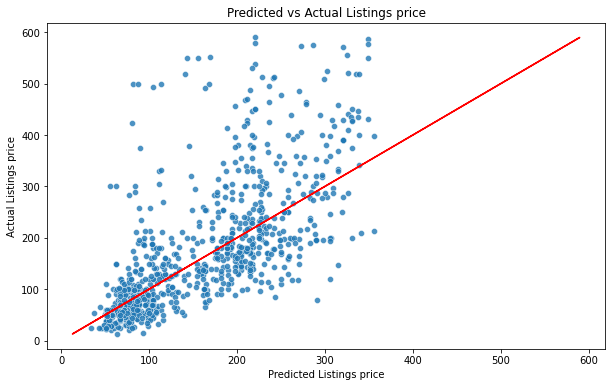

In [38]:
# Plot predicted vs actual values
plt.figure(figsize = (10,6))
sns.scatterplot(np.exp(model_pred_test), np.exp(y_test), alpha = 0.8)
plt.plot(np.exp(y_test), np.exp(y_test), color = 'r');
plt.xlabel("Predicted Listings price")
plt.ylabel("Actual Listings price")
plt.title("Predicted vs Actual Listings price")
plt.show()

In [58]:
# Create a dataframe with actual and predicted values
pred_df = pd.DataFrame({'Actual': np.exp(y_test), 'Predicted': np.exp(model_pred_test)})
pred_df['diff'] = pred_df['Actual'] - pred_df['Predicted']
pred_df['perc_dff'] = (pred_df['Actual'] - pred_df['Predicted'])/pred_df['Actual']*100
# Sort table by percentage difference
pred_df.sort_values(by = 'perc_dff', ascending = False, inplace = True)
pred_df.head()

,Actual,Predicted,diff,perc_dff
2093,424.0,68.219093,355.780907,83.910591
162,500.0,85.212364,414.787636,82.957527
811,500.0,90.249641,409.750359,81.950072
1880,300.0,58.641529,241.358471,80.452824
123,300.0,60.051952,239.948048,79.982683


In [59]:
# Filter out the listing based on predictions on test data
predicted_listings = listings[listings.index.isin(pred_df.index)]


# Merge the predicted listings dataframe with the predictions dataframe
predicted_listings = pd.merge(predicted_listings, pred_df, left_index = True, right_index = True)
# Sort the dataframe by percentage difference
predicted_listings.sort_values(by = 'perc_dff', ascending = False, inplace = True)
# Drop the price column 
predicted_listings.drop(columns = ['price'], inplace = True)

In [66]:
pred_df.describe()

,Actual,Predicted,diff,perc_dff
count,871.000000,871.000000,871.000000,871.000000
mean,174.552239,157.984482,16.567940,-13.525670
std,126.232660,80.935120,90.458966,54.170145
min,13.000000,39.595028,-211.213348,-470.581818
25%,75.000000,85.908268,-33.013638,-37.726929
50%,144.000000,153.374802,-5.621429,-5.159346
75%,229.500000,219.311928,40.185745,21.273655
max,590.000000,357.341278,414.787636,83.910591


From the scatterplot, we can see that the model performed fairly well on the test data with majority of the predicted scatter points falling closely to the actual price (shown by the diagonal line representing perfect prediction) for listings below $120. The model tend to underpredict the prices for listings above $120 and performed poorly for listings above $300 with the predicted prices being significantly lower than the actual prices.

On average, the model is able to predict the listings price within $16.56 difference between the actual price (or about 13.5%) for 60% of the listings. 

### Model interpretation using SHAP values

We can try to interpret the model using SHAP values first proposed by Lundberg and Lee as a unified approach to explain the output of any machine learning model. \
The benefits of using SHAP values are:
1) Global interpretability - It can be used to summarize the impact of each features on the prediction.
2) Local interpretability - It can be used to explain the prediction for a single observation as each observation gets its own SHAP values, allowing us to identify the features that contributed to the prediction.
3) SHAP values can be calculated for any tree-based models

In [63]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


1) Global interpretability

The plots that we can use to interpret the model are:
1) Variable importance plot - It shows the average SHAP value magnitude for each feature. The features with the highest average SHAP value magnitude are the most important features.
2) Beeswarm plot

2) Local interpretability

The plots that we can use to interpret the model are:
1) Force plot
2) Waterfall plot

#### Global Interpretability
##### Variable Importance plot

The Variance importance plot lists the most significant variables in descending order. \
The top variables contribute more to the model than the bottom ones and thus have high predictive power. 

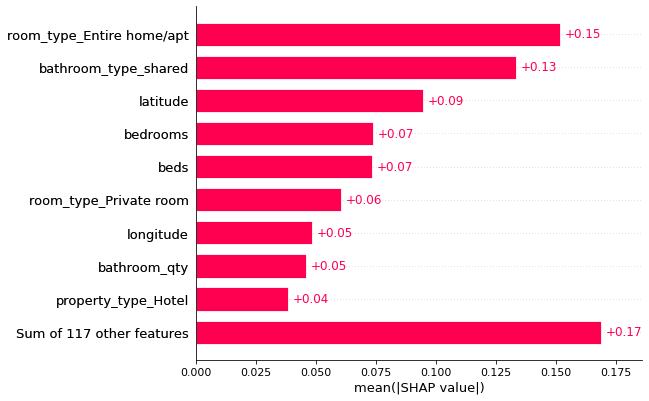

In [64]:
shap.plots.bar(shap_values, max_display=10) # default is max_display=12

In [ ]:
From the above plots, we can see that the most important features are:
- Room type: Entire home/apt
- Bathroom Type: Shared
- Latitude
- Bedrooms
- Beds
- Room type: Private Room
- Longitude
- Bathrooms
- Property Type: Hotel

##### Beeswarm plot

The SHAP value plot can also shows the postive and negative relationships of the predictors with the target variable.\
The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. \

This plot is made of all the dots in the train data. It delivers the following information:

**Feature importance**: Variables are ranked in descending order. (Similar to the variable importance plot) \
**Impact**: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction. \
**Original value**: Color shows whether that variable is high (in red) or low (in blue) for that observation. \
**Correlation**: A high number of guests the listing can accommodates has a high and positive impact on the listings price

The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

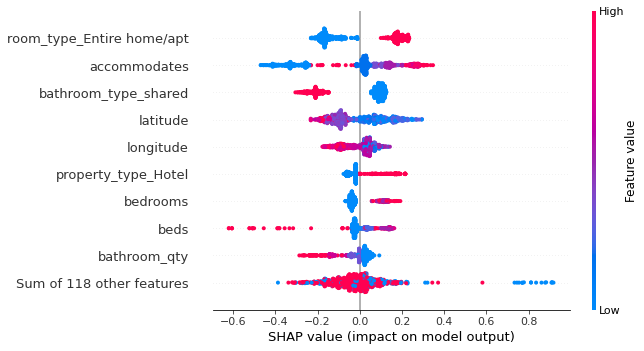

In [ ]:
shap.plots.beeswarm(shap_values)

#### Local Interpretability

We can also use SHAP to understand how each features impact the predicted price of each listing. \
The features are ordered by how much impact they have on the model output

The Waterfall plot and Force plot is made up of the different features of the listing and how it impact the final prediction price of the listing.

**E[f(x)]**: is the output value of the model's prediction for the given input. \
 **f(x)**: is the base value for the given input. It is the price that will be predicted if we did not know any features for the current output. \
**Red bars**: Features that push the listing price ***higher*** \
**Blue bars**: Features that pull the listing price ***lower*** \
**Width of bars**: Importance of the feature. The wider it is, the higher impact is has on the price \
**Values**: The logarithmn value of the features, base inputs and output. To get the value ofhow much the feature affect the price of the listing in $, take the exponential of the value

##### Waterfall plot for a single prediction

A waterfall plot powerfully shows why a case receives its prediction given its variable values. You start with the bottom of a waterfall plot and add (red) or subtract (blue) the values to get to the final prediction.

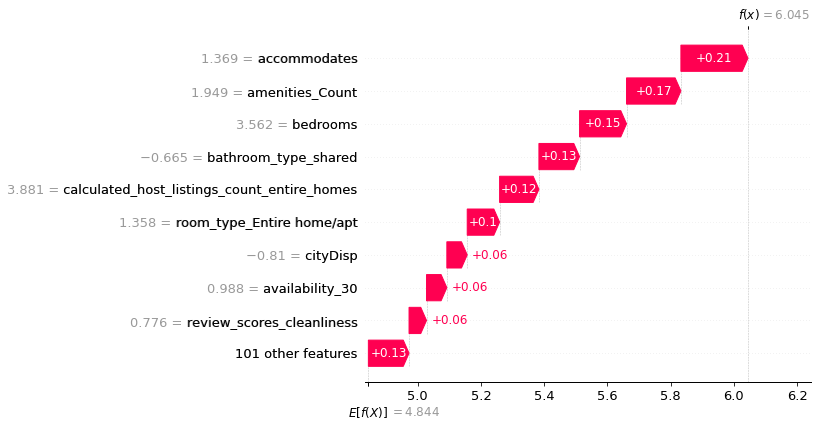

In [ ]:
# For the first observation
# Create a waterfall plot
shap.plots.waterfall(shap_values[0])

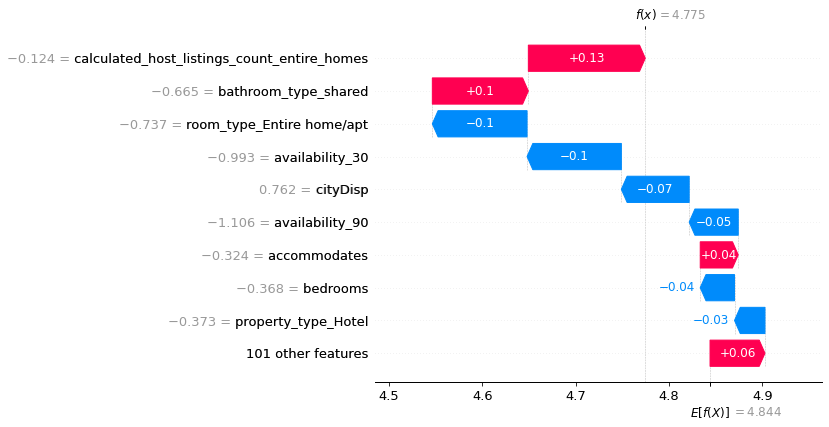

In [ ]:
# For the second observation
shap.plots.waterfall(shap_values[1])

##### Force plot for a single prediction

Similarly to the waterfall plot, the Force plot also give the same information as the waterfall plot.

In [ ]:
# We will plot the force plot for the first observation
shap.initjs()
shap.plots.force(shap_values[0])

In [ ]:
# We will plot the force plot for the second observation
shap.initjs()
shap.plots.force(shap_values[1])

### Model performance

A comparison of the full featured model and the reduced model is shown in the table below. 

There is a slight drop in the R2 values with an increase in RMSE for the Train and Test data. The generalisation score of the model have also slightly increased from 8.09% to 10.189 and that the model is able to explain about 61.7% of the variation in the listing prices with an RMSE price of $91.9 on the test data.

| Models            | R2 (Train) | R2 (Test) | RMSE (Train) | RMSE (Test) | Generalisation |
|-------------------|------------|-----------|--------------|-------------|----------------|
| XGBoost (Full)    | 0.754      | 0.693    | 81.6835      | 82.0812     | 8.09%       |
| XGBoost (Reduced) | 0.687     | 0.617     | 90.6974      | 91.9126     | 10.189%%         |

### Conclusion & Recommendations

Price prediction model and app is useful for homeowners to maximise their property occupancies and revenues at the same time. However, more work can be done to improve the production model further to generate a more accurate suggestion

Recommendations: \
As the listing price is set by the owner, a more accurate price data such as the actual price paid by the consumers can be used as the target variable \
Improve the dataset by incorporating other features such as property size, unit level and proximity features to F&B and attractions \
Remove hostels from the data as it has a high number of bedrooms/beds and have lower price than other property types, this affects the model performance